# Installing Packages and Dependencies

In [1]:
!pip install tensorflow-text==2.4.2
!pip install tf-models-official==2.4
!pip install tensorflow-gpu==2.4.2
!pip install delayed
!pip install alt-profanity-check
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import joblib
from profanity_check import predict, predict_prob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 3.4 MB 2.1 MB/s            
     |████████████████████████████████| 394.5 MB 36 kB/s              
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 462 kB 44.2 MB/s            
     |████████████████████████████████| 2.9 MB 34.9 MB/s            
     |████████████████████████████████| 3.8 MB 49.3 MB/s            
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77048 sha256=993cf71a83d0d0078290d8b59a54a3397dc235db0ffbd61abf5c9ec47d53fc7d
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Succe

2022-01-16 19:26:05.971434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to un

In [2]:
print(tf.__version__)

2.4.2


In [3]:
!nvidia-smi 

Sun Jan 16 19:26:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
tf.test.is_gpu_available()

2022-01-16 19:26:13.694493: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2022-01-16 19:26:13.695137: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-16 19:26:13.697288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-16 19:26:13.740650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 19:26:13.741276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-16 19:26:13.741341: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-16 19:26:13.779064: I tensorflow/stream_executor/platform/def

# Reading Training Data

In [5]:
df_train = pd.read_csv("../input/covid-misinfo/Constraint_English_Train.csv")
df_val = pd.read_csv("../input/covid-misinfo/Constraint_English_Val.csv")
df = pd.concat([df_train, df_val], ignore_index=True)
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [6]:
df.shape

(8560, 3)

# Training Data Insight

In [7]:
df.groupby('label').describe()

id                                                                 
        count         mean          std  min      25%     50%      75%     max
label                                                                         
fake   4080.0  2703.599755  1872.863928  1.0  1095.75  2193.5  4284.25  6419.0
real   4480.0  2649.909152  1884.354217  1.0  1053.75  2119.5  4275.25  6420.0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


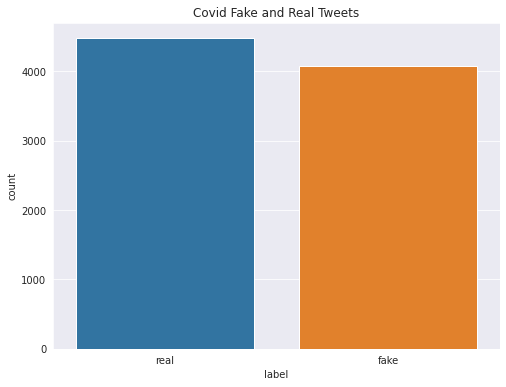

In [8]:
plt.figure(figsize=(8,6))
sns.set_style(style='darkgrid')
sns.countplot(df['label'])
plt.title("Covid Fake and Real Tweets")
plt.show()

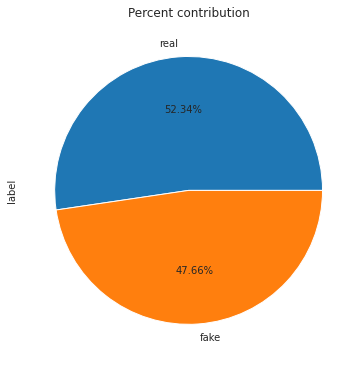

In [9]:
plt.figure(figsize=(6,8))
sns.set_style("darkgrid")
df["label"].value_counts().plot.pie(autopct='%0.2f%%')
plt.title("Percent contribution")
plt.show()

# Feature Engineering

In [10]:
def get_profanity_scores(text):
    embeds = []
    
    for line in tqdm(text):
        
        embeds.append(predict_prob([line])[0])
    
    assert len(text) == len(embeds)    
    return embeds

In [11]:
#textural features
def get_text_ft(text):
    tweet_len =  len(text)
    tweet_num_of_upper_char = sum([len([char for char in word if char.isupper()]) for word in text])
    tweet_num_of_qmarks = sum([len([char for char in word if char == '?']) for word in text]) 
    tweet_num_of_exclmmarks = sum([len([char for char in word if char == '!']) for word in text])
    return tweet_len, tweet_num_of_upper_char, tweet_num_of_qmarks, tweet_num_of_exclmmarks

In [12]:
df['profanity_scores'] = get_profanity_scores(df['tweet'])
df[['length','num_of_upper_char','num_of_qmarks','num_of_exclmmarks']] = df['tweet'].apply(lambda x: get_text_ft(x)).to_list()

100%|██████████| 8560/8560 [00:18<00:00, 470.78it/s]


In [13]:
df

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
0,1,The CDC currently reports 99031 deaths. In gen...,real,0.009465,190,6,0,0
1,2,States reported 1121 deaths a small rise from ...,real,0.031755,129,10,0,0
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,0.061657,131,16,0,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,0.034314,204,32,0,0
4,5,Populous states can generate large case counts...,real,0.014909,231,26,0,0
...,...,...,...,...,...,...,...,...
8555,2136,Donald Trump wrongly claimed that New Zealand ...,fake,0.011340,241,18,0,0
8556,2137,Current understanding is #COVID19 spreads most...,real,0.101561,230,17,0,0
8557,2138,Nothing screams “I am sat around doing fuck al...,fake,0.997964,184,6,0,0
8558,2139,Birx says COVID-19 outbreak not under control ...,fake,0.029324,102,9,0,0


In [14]:
df.nlargest(5, 'profanity_scores')

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
2160,2161,Local Man Sick To Fucking Death Hearing About ...,fake,0.999747,85,16,0,0
4895,4896,Stoner Strung Out To Fuck Thanks To Lockdown R...,fake,0.999376,81,11,0,0
8557,2138,Nothing screams “I am sat around doing fuck al...,fake,0.997964,184,6,0,0
4927,4928,Ellie Goulding says she’s amazed there were 20...,fake,0.993335,174,13,1,0
2677,2678,Coronavirus Cancels Billions of Man-Hours of P...,fake,0.967980,96,12,0,0


In [15]:
df.nlargest(5, 'num_of_qmarks')

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
5464,5465,"Says Sarah Huckabee Sanders tweeted, ???It???s...",fake,0.015965,338,28,34,0
3045,3046,???President Trump just announced that the ???...,fake,0.008184,219,13,17,1
3291,3292,"Quotes Anthony Fauci as writing, ???I reject t...",fake,0.082221,165,5,17,0
4420,4421,"Trey Gowdy said, ???I???m not saying COVID-19 ...",fake,0.109564,149,9,17,0
5902,5903,???The CDC has removed the ???Covid-19 Pandemi...,fake,0.010282,141,9,17,0


# Normalizing

In [16]:
df['length'] = MinMaxScaler().fit_transform(np.array(df['length']).reshape(-1,1))
df['num_of_upper_char'] = MinMaxScaler().fit_transform(np.array(df['num_of_upper_char']).reshape(-1,1))
df['num_of_qmarks'] = MinMaxScaler().fit_transform(np.array(df['num_of_qmarks']).reshape(-1,1))
df['num_of_exclmmarks'] = MinMaxScaler().fit_transform(np.array(df['num_of_exclmmarks']).reshape(-1,1))

In [17]:
df

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
0,1,The CDC currently reports 99031 deaths. In gen...,real,0.009465,0.019483,0.013304,0.0,0.0
1,2,States reported 1121 deaths a small rise from ...,real,0.031755,0.012574,0.022173,0.0,0.0
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,0.061657,0.012800,0.035477,0.0,0.0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,0.034314,0.021069,0.070953,0.0,0.0
4,5,Populous states can generate large case counts...,real,0.014909,0.024128,0.057650,0.0,0.0
...,...,...,...,...,...,...,...,...
8555,2136,Donald Trump wrongly claimed that New Zealand ...,fake,0.011340,0.025261,0.039911,0.0,0.0
8556,2137,Current understanding is #COVID19 spreads most...,real,0.101561,0.024014,0.037694,0.0,0.0
8557,2138,Nothing screams “I am sat around doing fuck al...,fake,0.997964,0.018804,0.013304,0.0,0.0
8558,2139,Birx says COVID-19 outbreak not under control ...,fake,0.029324,0.009515,0.019956,0.0,0.0


# Data Preprocessing

In [18]:
#Data Cleaning
ps = PorterStemmer()
nltk.download("stopwords")
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def cleaner(text):
    try:
        url_re = re.compile(r'(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#\$\%\^\&\*\(\)_\-\=\+\\\/\?\.\:\;\'\,]*)?')
        cleaned = url_re.sub("",text)
        
        hashtag_re = re.compile(r'(#\w+)')
        cleaned = hashtag_re.sub("",cleaned)
        
        screen_name_re = re.compile(r'(@\w+)')
        cleaned = screen_name_re.sub("", cleaned)
        
        emoji_re = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U0001F1F2-\U0001F1F4"  # Macau flag
                u"\U0001F1E6-\U0001F1FF"  # flags
                u"\U0001F600-\U0001F64F"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U0001F1F2"
                u"\U0001F1F4"
                u"\U0001F620"
                u"\u200d"
                u"\u2640-\u2642"
                "]+", flags=re.UNICODE)
        cleaned = emoji_re.sub("",cleaned)
        
        cleaned = cleaned.replace("."," ").replace("//"," ")
        cleaned = re.sub(r'[^a-zA-Z]', " ", cleaned) #Replacing all non-alphabets with " "
        cleaned = re.sub(r'\w+\d+', " ", cleaned) #Removes alphanumeric words

        cleaned = ps.stem(cleaned)

        cleaned = " ".join([word for word in cleaned.split() if len(word)>2]) #Removing words with len<2
        cleaned = ' '.join([word for word in cleaned.split() if word not in en_stopwords])

        cleaned = cleaned.strip() #Removing whitespaces
        cleaned = cleaned.lower() #Converting to lower case

    except:
        cleaned = ""
    return cleaned

In [20]:
df['tweet'] = df['tweet'].apply(lambda text: cleaner(text))
df.head()

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
0,1,cdc currently reports deaths general discrepan...,real,0.009465,0.019483,0.013304,0.0,0.0
1,2,states reported deaths small rise last tuesday...,real,0.031755,0.012574,0.022173,0.0,0.0
2,3,politically correct woman almost uses pandemic...,fake,0.061657,0.012800,0.035477,0.0,0.0
3,4,testing laboratories india august tests done,real,0.034314,0.021069,0.070953,0.0,0.0
4,5,populous states generate large case counts loo...,real,0.014909,0.024128,0.057650,0.0,0.0


# Generating Word Clouds

In [21]:
#Function to get word frequencies in the data
def get_word_freqs(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

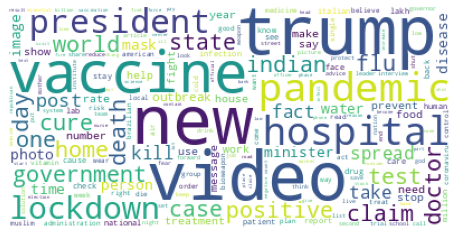

In [22]:
freq_words_fake = get_word_freqs(df[df['label']=='fake'],'tweet')
freq_words_fake = " ".join(freq_words_fake.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_fake)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

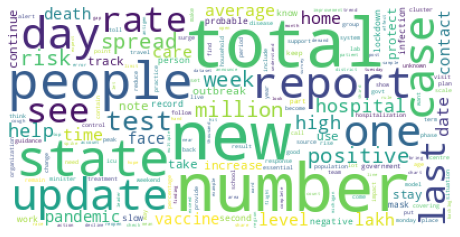

In [23]:
freq_words_real = get_word_freqs(df[df['label']=='real'],'tweet')
freq_words_real = " ".join(freq_words_real.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_real)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [24]:
#splitting the labels
df_real = df[df['label']=='real']
df_real.shape

(4480, 8)

In [25]:
df_fake = df[df['label']=='fake']
df_fake.shape

(4080, 8)

# Downsampling Data

In [26]:
#unbalanced data so we downsample it
df_real_downsampled = df_real.sample(df_fake.shape[0])
df_real_downsampled.shape

(4080, 8)

In [27]:
df_balanced = pd.concat([df_fake, df_real_downsampled])
df_balanced['label'].value_counts()

fake    4080
real    4080
Name: label, dtype: int64

In [28]:
df_balanced['fake'] = df_balanced['label'].apply(lambda x: 1 if x == 'fake' else 0)
df_balanced.sample(5)

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks,fake
5140,5141,update today new cases covid report managed is...,real,0.010122,0.028319,0.035477,0.0,0.000000,0
586,587,however lead drop positive cases time series d...,real,0.008382,0.011781,0.002217,0.0,0.000000,0
7857,1438,acted early activating state emergency committ...,real,0.000723,0.023335,0.035477,0.0,0.000000,0
347,348,trump announced roche medical company launch v...,fake,0.010376,0.011894,0.011086,0.0,0.428571,1
7047,628,british neuroscientist karl friston published ...,fake,0.039953,0.016878,0.019956,0.0,0.000000,1


In [29]:
df_features = df_balanced[["profanity_scores", "length","num_of_upper_char", "num_of_qmarks", "num_of_exclmmarks"]]
df_features

,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
2,0.061657,0.012800,0.035477,0.000000,0.0
7,0.008688,0.007363,0.031042,0.000000,0.0
8,0.037274,0.009289,0.004435,0.147059,0.0
9,0.019782,0.017218,0.026608,0.000000,0.0
11,0.027528,0.022655,0.033259,0.000000,0.0
...,...,...,...,...,...
3460,0.020322,0.017444,0.024390,0.000000,0.0
6003,0.054031,0.024014,0.004435,0.000000,0.0
2012,0.034873,0.013820,0.048780,0.029412,0.0
6066,0.004939,0.031831,0.055432,0.000000,0.0


# Model Construction

In [30]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2022-01-16 19:27:07.873372: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-16 19:27:07.873719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 19:27:07.874334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-16 19:27:07.874418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-16 19:27:07.874513: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-16 19:27:07.874555: I tensorflow/stream_executor/platform/

In [31]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [32]:
#Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
feature_input = tf.keras.layers.Input((5,))
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
concat= tf.keras.layers.Concatenate()([outputs['pooled_output'], feature_input])

#Neural Network Layers
dropout1 = tf.keras.layers.Dropout(0.1, name='dropout1')(concat)
fc1 = tf.keras.layers.Dense(512, activation='relu', name='fullyConnected1')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name='dropout2')(fc1)
fc2 = tf.keras.layers.Dense(256, activation='relu', name='fullyConnected2')(dropout2)
dense = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(fc2)

#Final Model
model = tf.keras.Model(inputs=[text_input, feature_input], outputs=[dense])

In [33]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [34]:
X_train = df_balanced[['tweet']] 
y_train = df_balanced[['fake']]

In [35]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )
]


# Training the Model

In [36]:
X_train

,tweet
2,politically correct woman almost uses pandemic...
7,obama calls trump coronavirus response chaotic...
8,clearly obama administration leave kind game p...
9,retraction hydroxychloroquine chloroquine with...
11,nba poised restart month march reported utah j...
...,...
3460,one case previously reported gombe state recor...
6003,week took data engine room made processes reli...
2012,questions find answers questions updated page
6066,second confirmed case nigeria detected due dil...


In [37]:
df_features

,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
2,0.061657,0.012800,0.035477,0.000000,0.0
7,0.008688,0.007363,0.031042,0.000000,0.0
8,0.037274,0.009289,0.004435,0.147059,0.0
9,0.019782,0.017218,0.026608,0.000000,0.0
11,0.027528,0.022655,0.033259,0.000000,0.0
...,...,...,...,...,...
3460,0.020322,0.017444,0.024390,0.000000,0.0
6003,0.054031,0.024014,0.004435,0.000000,0.0
2012,0.034873,0.013820,0.048780,0.029412,0.0
6066,0.004939,0.031831,0.055432,0.000000,0.0


In [38]:
h1 = model.fit(x=[X_train, df_features], y=y_train, validation_split=0.25, epochs= 200, callbacks = callbacks, verbose=1)

Epoch 1/200


2022-01-16 19:27:45.712987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-16 19:27:46.490494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


192/192 [==============================] - 67s 299ms/step - loss: 0.6006 - accuracy: 0.6892 - precision: 0.7239 - recall: 0.8634 - val_loss: 0.6514 - val_accuracy: 0.6853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
192/192 [==============================] - 56s 290ms/step - loss: 0.3941 - accuracy: 0.8264 - precision: 0.8519 - recall: 0.8962 - val_loss: 0.4952 - val_accuracy: 0.7809 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
192/192 [==============================] - 56s 292ms/step - loss: 0.3596 - accuracy: 0.8405 - precision: 0.8632 - recall: 0.9019 - val_loss: 0.8213 - val_accuracy: 0.5618 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
192/192 [==============================] - 56s 291ms/step - loss: 0.3579 - accuracy: 0.8458 - precision: 0.8643 - recall: 0.9104 - val_loss: 0.3635 - val_accuracy: 0.8348 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
192/192 [==============================] - 56s 293ms/ste

In [39]:
h1.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])

In [40]:
def plot_metrics(h):
    #Plotting metrics
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss']);
    plt.plot(h.history['val_loss']);
    plt.title("Loss vs Epochs");
    plt.ylabel("Loss");
    plt.xlabel("Epochs");
    plt.legend(['train', 'val']);

    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [41]:
# plot_metrics(h1)

In [42]:
model.save('BERT_Simple_TextFt.h5')

# Model Evaluation on Test Data

In [43]:
#Preprocessing
df_test = pd.read_csv("../input/covid-misinfo/Constraint_English_Test.csv")
df_test['tweet'] = df_test['tweet'].apply(lambda text: cleaner(text))
df_test['fake'] = df_test['label'].apply(lambda x: 1 if x == 'fake' else 0)
X_test = df_test[['tweet']] 
y_test = df_test[['fake']]

X_test.shape

(2140, 1)

In [44]:
#Feature Extraction
df_test['profanity_scores'] = get_profanity_scores(df_test['tweet'])
df_test[['length','num_of_upper_char','num_of_qmarks','num_of_exclmmarks']] = df_test['tweet'].apply(lambda x: get_text_ft(x)).to_list()

#Normalizing
df_test['length'] = MinMaxScaler().fit_transform(np.array(df_test['length']).reshape(-1,1))
df_test['num_of_upper_char'] = MinMaxScaler().fit_transform(np.array(df_test['num_of_upper_char']).reshape(-1,1))
df_test['num_of_qmarks'] = MinMaxScaler().fit_transform(np.array(df_test['num_of_qmarks']).reshape(-1,1))
df_test['num_of_exclmmarks'] = MinMaxScaler().fit_transform(np.array(df_test['num_of_exclmmarks']).reshape(-1,1))

df_test_features = df_test[["profanity_scores", "length","num_of_upper_char", "num_of_qmarks", "num_of_exclmmarks"]]

100%|██████████| 2140/2140 [00:04<00:00, 527.34it/s]


In [45]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x=[X_test,df_test_features], y=y_test)

print("Test Loss: ", test_loss)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test Accuracy: ", test_accuracy)

67/67 [==============================] - 15s 222ms/step - loss: 0.3487 - accuracy: 0.8523 - precision: 0.7963 - recall: 0.9275
Test Loss:  0.3486746549606323
Test Precision:  0.7962962985038757
Test Recall:  0.927450954914093
Test Accuracy:  0.8523364663124084
